In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(ConvVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # Output: 32 x 16 x 16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # Output: 64 x 8 x 8
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),# Output: 128 x 4 x 4
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 4 * 4),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load the dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Selecting only two classes, planes (0) and cats (3)
class_indices = [0,3]
indices = [i for i, (_, label) in enumerate(train_dataset) if label in class_indices]
subset_train_dataset = torch.utils.data.Subset(train_dataset, indices)

test_indices = [i for i, (_, label) in enumerate(test_dataset) if label in class_indices]
subset_test_dataset = torch.utils.data.Subset(test_dataset, test_indices)

train_loader = torch.utils.data.DataLoader(subset_train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(subset_test_dataset, batch_size=len(test_dataset), shuffle=True)

def imshow_cifar10(img):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.247, 0.243, 0.261])
    img = img.numpy()
    img = std[:, None, None] * img + mean[:, None, None]  # Unnormalize
    img = np.transpose(img, (1, 2, 0))  # Rearrange dimensions to HWC for plotting
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')

Files already downloaded and verified
Files already downloaded and verified


In [14]:
VAE = ConvVAE(latent_dim = 32).to(device)
optimizer = torch.optim.Adam(VAE.parameters(), lr=0.001)
criterion = nn.MSELoss(reduction='sum')

def KL_divergence(mu, logvar, reduction = 'mean'):
    if reduction == 'mean':
        return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    else:
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

n_epochs = 40
for epoch in range(n_epochs):
    VAE.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        reconstructed, mu, logvar = VAE(images)
        reconstruction_loss = criterion(reconstructed, images)
        kl_loss = KL_divergence(mu, logvar)
        loss = reconstruction_loss + kl_loss
        loss.backward()
        optimizer.step()

    # Evaluation phase
    VAE.eval()  # Set the network to evaluation mode

    # Calculate training loss over the entire training set
    train_loss = 0
    with torch.no_grad():  # No need to track gradients
        for images,_ in train_loader:
            images = images.to(device)
            train_output, mu, logvar = VAE(images)
            train_loss += ((criterion(train_output, images)+KL_divergence(mu,logvar)).item()/images.size(0))           
    train_loss /= len(train_loader)

    # Same for test
    test_loss = 0
    with torch.no_grad():
        for images,_ in test_loader:
            images = images.to(device)
            test_output, mu, logvar = VAE(images)
            test_loss += ((criterion(test_output, images)+KL_divergence(mu,logvar)).item()/images.size(0))
    test_loss /= len(test_loader)
    print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss}, Test Loss: {test_loss}')

Epoch 1/40 - Train Loss: 971.511898745397, Test Loss: 966.0638125
Epoch 2/40 - Train Loss: 649.8071071357484, Test Loss: 652.8059375
Epoch 3/40 - Train Loss: 587.3047998513385, Test Loss: 591.82425
Epoch 4/40 - Train Loss: 558.7067017767839, Test Loss: 566.57825
Epoch 5/40 - Train Loss: 549.4732992573149, Test Loss: 560.542
Epoch 6/40 - Train Loss: 542.2719922885773, Test Loss: 555.63675
Epoch 7/40 - Train Loss: 539.097800868332, Test Loss: 555.1559375
Epoch 8/40 - Train Loss: 532.1128248469845, Test Loss: 552.25425
Epoch 9/40 - Train Loss: 527.723424826458, Test Loss: 549.94625
Epoch 10/40 - Train Loss: 530.8765999374875, Test Loss: 556.2101875
Epoch 11/40 - Train Loss: 520.7078639716859, Test Loss: 549.307625
Epoch 12/40 - Train Loss: 512.8430127186381, Test Loss: 544.8556875
Epoch 13/40 - Train Loss: 521.4220546066381, Test Loss: 554.8805
Epoch 14/40 - Train Loss: 504.63984126194265, Test Loss: 542.3310625
Epoch 15/40 - Train Loss: 503.7349420049388, Test Loss: 543.9319375
Epoch 16/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original Images


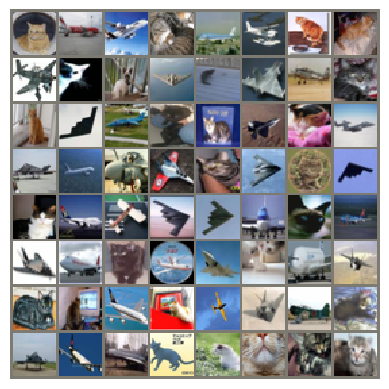

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Images


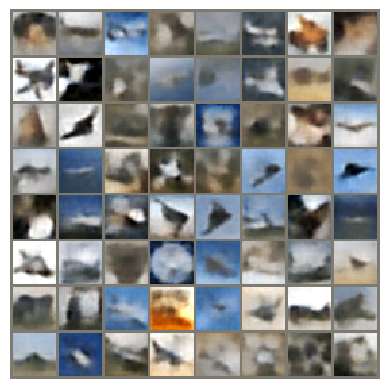

In [15]:
#after training, put back the network in the cpu
VAE.to('cpu')

# Get a batch of test images
images, _ = next(iter(test_loader))
images = images[:64]
original_images = images  # Save the original images for comparison

# Pass the images through the network and get the reconstructed images
reconstructed, _, _ = VAE(images)

# Display original images
print("Original Images")
imshow_cifar10(torchvision.utils.make_grid(original_images))
plt.show()

# Display reconstructed images
print("Reconstructed Images")
imshow_cifar10(torchvision.utils.make_grid(reconstructed))
plt.show()

Start Image


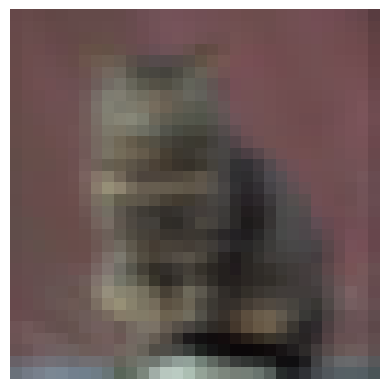

End Image


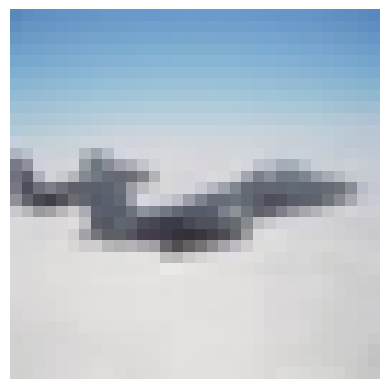

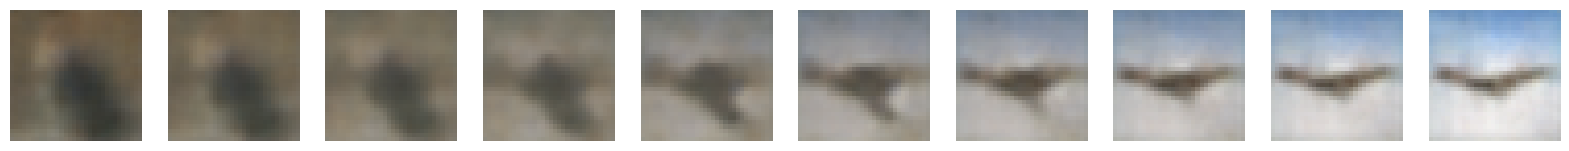

In [21]:
def interpolate_points(p1, p2, n_steps=10):
    # Linear interpolation between two points in latent space
    ratios = np.linspace(0, 1, num=n_steps)
    vectors = [(1 - alpha) * p1 + alpha * p2 for alpha in ratios]
    return np.array(vectors)

def interpolate_points(p1, p2, n_steps=10):
    # Ensure p1 and p2 are NumPy arrays for consistent shape handling
    if isinstance(p1, torch.Tensor):
        p1 = p1.detach().cpu().numpy()
    if isinstance(p2, torch.Tensor):
        p2 = p2.detach().cpu().numpy()

    # Linear interpolation
    ratios = np.linspace(0, 1, num=n_steps)
    vectors = [(1 - alpha) * p1 + alpha * p2 for alpha in ratios]
    return np.stack(vectors)  # Use np.stack to correctly handle the array shapes


def generate_images_from_path(vae, start_point, end_point, n_steps=10):
    # Interpolate between the start and end points
    z_points = interpolate_points(start_point, end_point, n_steps=n_steps)
    # Generate images along the path
    images = []
    with torch.no_grad():
        for z in z_points:
            z_tensor = torch.from_numpy(z).float().squeeze()
            z_tensor = z_tensor.unsqueeze(0)
            img = vae.decoder(z_tensor).to('cpu')
            images.append(img.squeeze())  # Remove batch dimension
    
    # Plotting
    fig, axes = plt.subplots(1, n_steps, figsize=(n_steps * 2, 2))
    for i, img in enumerate(images):
        # Call imshow_cifar10 as a standalone function
        plt.sca(axes[i])  # Set the current Axes to axes[i] before calling imshow_cifar10
        imshow_cifar10(img)  # Now img is a Tensor; ensure imshow_cifar10 can handle it directly or convert to numpy array inside the function
        axes[i].axis('off')
    plt.show()
    return z_points

def select_two_random_images(data_loader):
    images, _ = next(iter(data_loader))  # Get the first batch of images
    idx1, idx2 = np.random.choice(len(images), 2, replace=False)  # Randomly select two indices
    img1, img2 = images[idx1:idx1+1], images[idx2:idx2+1]  # Slice tensors to keep batch dimension
    return img1, img2

# Select random images
img_start, img_end = select_two_random_images(test_loader)
# Encode images to get latent representations
with torch.no_grad():
    encoded = VAE.encoder(img_start)
    mu_start = VAE.fc_mu(encoded)
    encoded = VAE.encoder(img_end)
    mu_end = VAE.fc_mu(encoded)

#show the images
print("Start Image")
imshow_cifar10(torchvision.utils.make_grid(img_start))
plt.show()
print("End Image")
imshow_cifar10(torchvision.utils.make_grid(img_end))
plt.show()

latent_path = generate_images_from_path(VAE, mu_start, mu_end, n_steps=10)

(2000, 32)
(10, 1, 32)


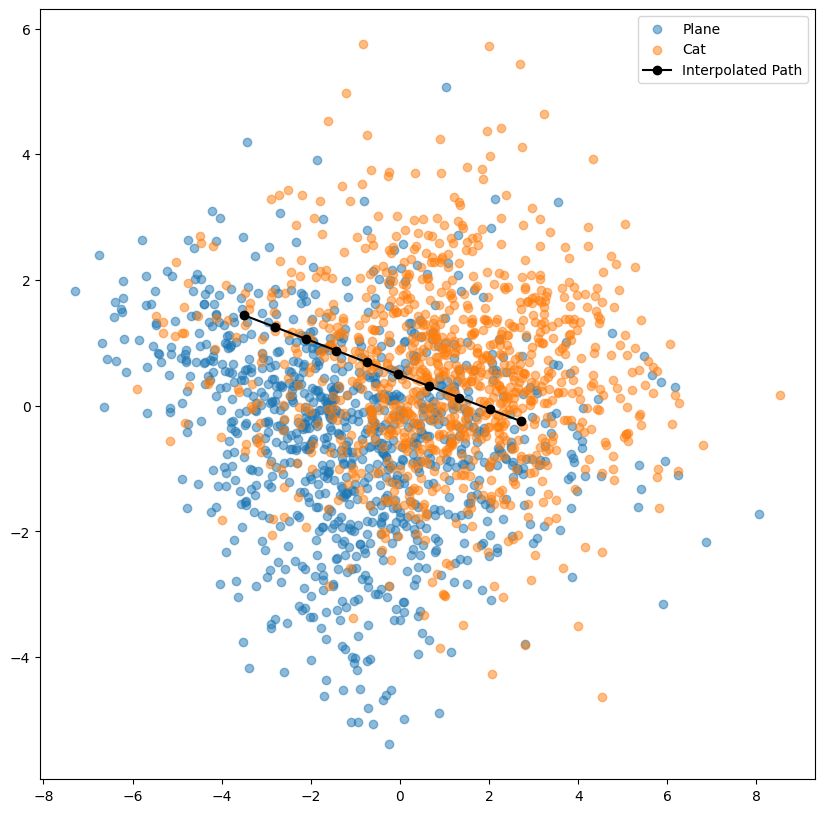

In [22]:
#get the latent representations of the entire test set
test_images, test_labels = next(iter(test_loader))
with torch.no_grad():
    encoded = VAE.encoder(test_images)
    mu = VAE.fc_mu(encoded)
    mu = mu.numpy()
    test_labels = test_labels.numpy()
#convert in 2D with PCA
print(mu.shape)
print(latent_path.shape)
latent_path = latent_path.squeeze(1)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(mu)
pca_path = pca.transform(latent_path)

#plot the 2D representation
plt.figure(figsize=(10, 10))
plt.scatter(pca_result[test_labels == 0, 0], pca_result[test_labels == 0, 1], label='Plane', alpha=0.5)
plt.scatter(pca_result[test_labels == 3, 0], pca_result[test_labels == 3, 1], label='Cat', alpha=0.5)
plt.plot(pca_path[:, 0], pca_path[:, 1], marker='o', color='black', label='Interpolated Path')
plt.legend()
plt.show()

